In [1093]:
from scipy.special import erfc
from lmfit import Model
from lmfit.models import ConstantModel
import matplotlib.pyplot as plt
import numpy as np
from functools import partial

from uncertainties import ufloat

from utils import load_data

In [1094]:
file = "data/Lebensdauer-Positronen.Spe"

In [1095]:
data, roi = load_data(file, only_roi=False)
roi = np.arange(2000, 3000)
data = data[roi]

In [1096]:
time_scale = ufloat(6.07, 0.05)*1e-3 # ns/channel
time = roi * time_scale.n

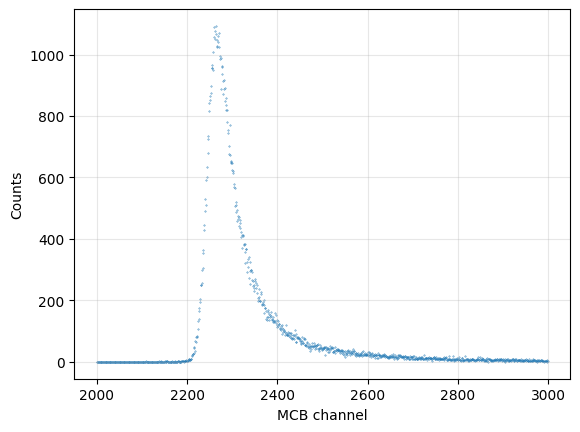

In [1097]:
plt.scatter(roi, data, s=0.1)
plt.grid(alpha=.3)
plt.xlabel('MCB channel')
plt.ylabel('Counts')
plt.show()

In [1098]:
def expgaussian(x, amplitude=1, center=0, sigma=1.0, gamma=1.0):
    """ an alternative exponentially modified Gaussian."""
    dx = center - x
    return amplitude * np.exp(gamma * dx) * erfc(dx / (np.sqrt(2) * sigma))


def gaussian(x, amplitude=1, center=0, sigma=1.0):
    """ an alternative exponentially modified Gaussian."""
    dx = center - x
    return amplitude * np.exp(-dx ** 2 / (2 * sigma ** 2))


def total_model(x, alpha, beta, delta, exp_amplitude, amplitude, center, sigma, gamma, gamma2, gamma3):
    expgauss = partial(expgaussian, x=x, amplitude=exp_amplitude, center=center, sigma=sigma)
    expgauss1 = expgauss(gamma=gamma)
    expgauss2 = expgauss(gamma=gamma2)
    expgauss3 = expgauss(gamma=gamma3)
    gauss = gaussian(x, amplitude=amplitude, center=center, sigma=sigma)
    return alpha * expgauss1 + beta * expgauss2 + delta * expgauss3 + gauss

In [1099]:
model = Model(total_model) + ConstantModel()

In [1100]:
init_values = {
    'alpha': {'value':0.5, 'min':0, 'max':1},
    'beta': {'value':0.5, 'min':0, 'max':1},
    'delta': {'value':0.5, 'min':0, 'max':1, 'vary': False, 'expr': '1 - alpha - beta'},
    'gamma': {'value': 0.01755400, 'min': 0, 'max': 1},
    'gamma2': {'value': 0.01755400, 'min': 0, 'max': 1},
    'gamma3': {'value': 0.01755400, 'min': 0, 'max': 1},
    
    'exp_amplitude': {'value': 788.681733, 'min': 100, 'max': 1200},
    'amplitude': {'value': .1, 'min': 0, 'max': 900},
    'center': {'value': 2247, 'min': 2200, 'max': 2400},
    'sigma': {'value': 13.9612544, 'min': 0, 'max': 50},
    'c': {'value': 0, 'min': 0, 'max': 50},
}
params = model.make_params(**init_values)

In [1101]:
results = model.fit(data, params, x=roi,)
dely = results.eval_uncertainty(x=roi, sigma=2)

In [1102]:
print(results.fit_report())

[[Model]]
    (Model(total_model) + Model(constant))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 2670
    # data points      = 1000
    # variables        = 10
    chi-square         = 99337.2537
    reduced chi-square = 100.340660
    Akaike info crit   = 4618.52066
    Bayesian info crit = 4667.59822
    R-squared          = 0.99794844
[[Variables]]
    alpha:          0.23122920 +/- 0.24676286 (106.72%) (init = 0.5)
    beta:           0.71892684 +/- 0.27745027 (38.59%) (init = 0.5)
    delta:          0.04984396 +/- 0.03568940 (71.60%) == '1 - alpha - beta'
    exp_amplitude:  891.754407 +/- 60.8098887 (6.82%) (init = 788.6817)
    amplitude:      6.2746e-05 +/- 29.1298787 (46425326.92%) (init = 0.1)
    center:         2251.97827 +/- 1.65472952 (0.07%) (init = 2247)
    sigma:          15.2813153 +/- 0.57205926 (3.74%) (init = 13.96125)
    gamma:          0.01377232 +/- 0.00764453 (55.51%) (init = 0.017554)
    gamma2:         0.02819673 +/- 0.005

In [1103]:
results.params.pretty_print()

Name              Value      Min      Max   Stderr     Vary     Expr Brute_Step
alpha            0.2312        0        1   0.2468     True     None     None
amplitude      6.275e-05        0      900    29.13     True     None     None
beta             0.7189        0        1   0.2775     True     None     None
c                0.6056        0       50   0.7867     True     None     None
center             2252     2200     2400    1.655     True     None     None
delta           0.04984        0        1  0.03569    False 1 - alpha - beta     None
exp_amplitude     891.8      100     1200    60.81     True     None     None
gamma           0.01377        0        1 0.007645     True     None     None
gamma2           0.0282        0        1  0.00533     True     None     None
gamma3         0.004383        0        1 0.001302     True     None     None
sigma             15.28        0       50   0.5721     True     None     None


In [1104]:
print(results.params['alpha'].value + results.params['beta'].value + results.params['delta'].value)

1.0


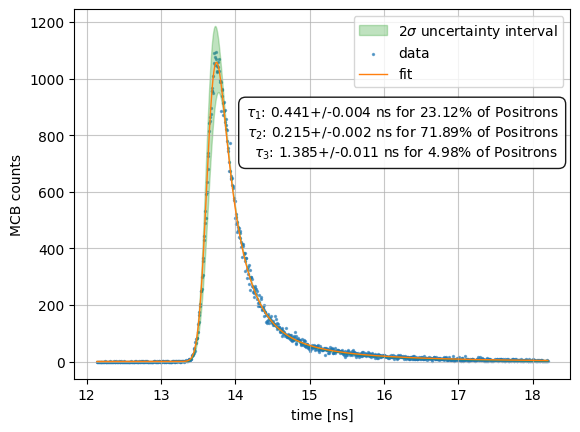

In [1105]:

plt.fill_between(time, results.best_fit - dely,
                 results.best_fit + dely, 
                label=r'$2\sigma$ uncertainty interval',
                color='tab:green',
                alpha=0.3,
                zorder=1)
plt.scatter(time, data, s=2, label='data', alpha=.6, c='tab:blue', zorder=0)
plt.plot(time, results.best_fit, lw=1, label='fit', c='tab:orange', zorder=2)
texts = []
cnt = 0
for par in results.params:
    if 'gamma' in par:
        cnt += 1
        gamma = results.params[par].value / time_scale
        if par == 'gamma':
            part = results.params['alpha'].value
        elif par == 'gamma2':
            part = results.params['beta'].value
        else:
            part = results.params['delta'].value
        texts.append(rf'$\tau_{cnt}$: {1./gamma:.3f} ns for {part*100:.2f}% of Positrons')
plt.text(s='\n'.join(texts), x=18.35, y= 910, ha='right', va='top', fontsize=10, 
         bbox=dict(boxstyle='round,pad=0.5', ec='black', fc='white', alpha=.9))
plt.xlabel('time [ns]')
plt.ylabel('MCB counts')
plt.legend()
plt.grid(alpha=.7)
plt.savefig('figures/Lebensdauer-Positronen.png', format='png', dpi=500, transparent=True)
plt.show()